In [15]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from explore.funcs import load_datasets, get_docs

In [16]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [17]:
model = SentenceTransformer("BAAI/bge-m3")

In [18]:
datasets = load_datasets(["ru", "zh", "fa"])

datasets

{'ru': Dataset(id='neuclir/1/ru/hc4-filtered', provides=['docs', 'queries', 'qrels']),
 'zh': Dataset(id='neuclir/1/zh/hc4-filtered', provides=['docs', 'queries', 'qrels']),
 'fa': Dataset(id='neuclir/1/fa/hc4-filtered', provides=['docs', 'queries', 'qrels'])}

In [19]:
documents = pd.DataFrame(datasets["ru"].docs_iter())

documents.count()

doc_id     964719
title      964719
text       964719
url        964719
time       215421
cc_file    964719
dtype: int64

In [20]:

queries = pd.DataFrame(datasets["ru"].queries_iter())

queries

,query_id,title,description,ht_title,ht_description,mt_title,mt_description,narrative_by_relevance,report,report_url,report_date,translation_lang
0,3,British royal news impacts,What political and economic impacts does news ...,Влияние британских королевских новостей,Какое политическое и экономическое влияние нов...,Британские королевские новости влияют,Какие политические и экономические последствия...,{'very_valuable': 'Information regarding econo...,Announcement of engagement\nPrincess Eugenie o...,https://en.wikipedia.org/w/index.php?title=Wed...,2018-05-13,ru
1,6,Gibraltar's Sovereignty After Brexit,How will Gibraltar's sovereignty be impacted b...,Суверенитет Гибралтара после Брексита,Как на суверенитет Гибралтара повлияет на пере...,Суверенитет Гибралтара после Брексита,Как повлияют на суверенитет Гибралтара перегов...,{'very_valuable': 'Gibraltar will remain a ter...,Sovereignty\nSee also: Disputed status of Gibr...,https://en.wikipedia.org/w/index.php?title=Eff...,2018-11-26,ru
2,13,US-South Korea Trade Agreement,How will South Korea benefit from or be harmed...,США-Южнокорейское торговое соглашение,Как Южная Корея выиграет или пострадает от пер...,Торговое соглашение между США и Южной Кореей,Каким образом Южная Корея извлечет выгоду из с...,"{'very_valuable': 'N/A', 'somewhat_valuable': ...",South Korea reactions\n\t\nThis section is in ...,https://en.wikipedia.org/w/index.php?title=Uni...,2018-02-20,ru
3,14,North Korean Earthquakes and Nuclear Testing,Are earthquakes in North Korea being caused by...,Северокорейские землетрясения и ядерное испытание,Являются ли землетрясения в Северной Корее сле...,Северокорейские землетрясения и ядерные испытания,Являются ли землетрясения в Северной Корее при...,"{'very_valuable': 'N/A', 'somewhat_valuable': ...","On 3 September, at 3:31 AM UTC, the United Sta...",https://en.wikipedia.org/w/index.php?title=201...,2017-09-22,ru
4,101,Shipwrecks and Historical European Trade,What information about trade and shipping has ...,Кораблекрушения и историческая Европейская тор...,Какая информация о торговле и судоходстве была...,Кораблекрушения и историческая европейская тор...,Какая информация о торговле и судоходстве была...,{'very_valuable': 'Shipwrecks that belonged to...,Portuguese discoveries (Portuguese: Descobrime...,https://en.wikipedia.org/w/index.php?title=Por...,2018-05-16,ru
5,103,African Extremist School Girls Kidnapping,What is known about instances of extremist or ...,Похищение школьниц из числа африканских экстре...,"Что известно о случаях, когда экстремистские и...",Африканские Экстремистские Школьные Девушки По...,Что известно о случаях похищения девочками из ...,{'very_valuable': 'The number and instances of...,"On the night of 14–15 April 2014, 276 female s...",https://en.wikipedia.org/w/index.php?title=Chi...,2018-02-11,ru
6,105,Mount Sinabung Eruptions,How long will Mount Sinabung's eruptions last ...,Извержения горы Синабунг,Как долго продлится извержение горы Синабунг и...,Разрушения на горе Синабунг,Как долго будут продолжаться извержения горы С...,"{'very_valuable': 'None found', 'somewhat_valu...",Mount Sinabung erupted after a centuries-long ...,https://en.wikipedia.org/w/index.php?title=Mou...,2018-02-19,ru
7,107,UN Climate Change Economic Analysis,What is the economic impact of climate change ...,ООН Изменение Климата Экономический Анализ,Какие экономические последствия изменения клим...,Экономический анализ изменения климата ООН,Каково экономическое воздействие изменения кли...,{'very_valuable': 'Articles that described the...,The United Nations Framework Convention on Cli...,https://en.wikipedia.org/w/index.php?title=Uni...,2018-10-06,ru
8,108,Saudi Arabic movie theater restrictions,What restrictions did Saudi Arabia put on movi...,Ограничения кинотеатра в Саудовской Аравии,Какие ограничения Саудовская Аравия наложила н...,Ограничения саудовского арабского кинотеатра,Какие ограничения были введены Саудовской Арав...,{'very_valuable': 'Described the restriction

In [21]:
qrels = pd.DataFrame(datasets["ru"].qrels_iter())


# Check the count of each relevance score in qrels
relevance_counts = qrels["relevance"].value_counts()

# Determine the minimum count among relevance scores 0, 1, and 3 to ensure equal sampling
min_sample_count = 10

# Sample equally from each relevance score based on the minimum count
sample_0 = qrels[qrels["relevance"] == 0].sample(n=min_sample_count, random_state=42)
sample_1 = qrels[qrels["relevance"] == 1].sample(n=min_sample_count, random_state=42)
sample_3 = qrels[qrels["relevance"] == 3].sample(n=min_sample_count, random_state=42)

# Concatenate the samples into one DataFrame
sample = pd.concat([sample_0, sample_1, sample_3]).reset_index(drop=True)

use_full_dataset = input("Run Training on Full HC4 RU Dataset? (y/n)")

if use_full_dataset == "y":
    sample = qrels

doc_ids = sample["doc_id"].values
query_ids = sample["query_id"].values

docs = documents[documents["doc_id"].isin(doc_ids)]
queries = queries[queries["query_id"].isin(query_ids)]

print(docs["doc_id"].count())
print(queries["query_id"].count())

sample

680
54


,query_id,doc_id,relevance,iteration
0,3,07d5796e-e55f-469f-b158-88a8aa53131d,0,0
1,3,084c6487-5838-4043-98e3-c3837bf6e484,1,0
2,3,0997514d-dc9c-478b-bb0f-abb9747f2b11,0,0
3,3,12239503-c6a6-40cb-9bb6-3452fa9b3b99,0,0
4,3,158e7a45-76ee-4746-a2d0-ca97880476b1,0,0
...,...,...,...,...
3230,256,b1971da5-b793-4ea2-bbfb-7b3804364208,0,0
3231,256,ba2840e6-dac2-4b12-ba49-0eef094bf9c8,0,0
3232,256,c2bdf94e-8c69-4ab9-87f6-0377af3a727c,0,0
3233,256,d71b29cb-de13-438f-85d7-ed8480b6cc2f,0,0


In [22]:
pool = model.start_multi_process_pool(["cpu", "cpu", "cpu", "cpu"])
doc_embeddings = model.encode_multi_process(docs["text"].values, pool=pool, batch_size=10, show_progress_bar=True)
title_embeddings = model.encode_multi_process(docs["title"].values, pool=pool, batch_size=10, show_progress_bar=True)
query_embeddings = model.encode_multi_process(queries["description"].values, batch_size=10, show_progress_bar=True, pool=pool)

model.stop_multi_process_pool(pool)


Chunks:   0%|          | 0/40 [00:00<?, ?it/s]

Chunks:   0%|          | 0/40 [00:00<?, ?it/s]

Chunks:   0%|          | 0/27 [00:00<?, ?it/s]

In [23]:
doc_embedding_pairs = {doc_id: embedding for doc_id, embedding in zip(docs["doc_id"], doc_embeddings)}
title_embedding_pairs = {doc_id: embedding for doc_id, embedding in zip(docs["doc_id"], title_embeddings)}
query_embedding_pairs = {query_id: embedding for query_id, embedding in zip(queries["query_id"], query_embeddings)}

In [24]:
def cosine_similarity(query_embedding, doc_embedding):
    return np.dot(query_embedding, doc_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(doc_embedding))

In [25]:
# Assuming sample, query_embeddings, and doc_embeddings are already defined

results = []

for i, row in sample.iterrows():
    query_id = row["query_id"]
    doc_id = row["doc_id"]
    relevance = row["relevance"]

    # Check if the query_id exists in the mapping and if doc_id exists in the documents
    if query_id in query_embedding_pairs and doc_id in doc_embedding_pairs:
        query_embedding = query_embedding_pairs[query_id]
        doc_embedding = doc_embedding_pairs[doc_id]
        title_embedding = title_embedding_pairs[doc_id]
        
        similarity_doc = cosine_similarity(query_embedding, doc_embedding)
        similarity_title = cosine_similarity(query_embedding, title_embedding)
        harmonic_mean = stats.hmean([similarity_doc, similarity_title])
        max = np.amax([similarity_doc, similarity_title])
        
        score = 0
        
        results.append([query_id, doc_id, similarity_doc, similarity_title, harmonic_mean, max, score, relevance])

# Convert the results list to a DataFrame
df = pd.DataFrame(results, columns=["query_id", "doc_id", "similarity_doc", "similarity_title", "hmean", "argmax", "score", "relevance"])

# Print the resulting DataFrame
df.sort_values(["query_id", "relevance"])


,query_id,doc_id,similarity_doc,similarity_title,hmean,argmax,score,relevance
55,101,1023b31b-eff0-482e-beb5-74218d220a2e,0.595196,0.619026,0.606877,0.619026,0,0
57,101,1dd7fc7c-c54f-467d-8862-3ee417893ffa,0.478892,0.389411,0.429541,0.478892,0,0
58,101,34992543-a1a7-4a5f-92ed-d620428b4691,0.543168,0.554924,0.548983,0.554924,0,0
59,101,40049d71-0c2d-4d6e-962a-487306995dae,0.503482,0.541177,0.521649,0.541177,0,0
61,101,a0fdf7a1-6979-43e9-8555-ea9ddb3b10f9,0.409042,0.535025,0.463628,0.535025,0,0
...,...,...,...,...,...,...,...,...
17,6,ad60088c-f295-45d6-ad9b-4f498b7de791,0.618871,0.598164,0.608341,0.618871,0,1
19,6,bdc4e621-76ab-435c-8822-9c4050df5a41,0.463762,0.377533,0.416228,0.463762,0,1
20,6,c0671004-af8c-45f0-a75b-c18438bb9f48,0.491947,0.366677,0.420174,0.491947,0,1
22,6,ddf1e476-6730-4dfd-8fdb-5029af3727f6,0.541970,0.450418,0.491971,0.541970,0,1


In [26]:
# calculate average similiarty for relevance

df.groupby("relevance").mean(numeric_only=True)

,similarity_doc,similarity_title,hmean,argmax,score
relevance,,,,,
0,0.486688,0.479705,0.479862,0.511696,0.0
1,0.552048,0.520123,0.532178,0.568753,0.0
3,0.575816,0.565443,0.567625,0.602543,0.0


In [27]:
#evalute runs

import ir_measures
from ir_measures import *
# Define the columns to run IR measures on

# Define the columns to run IR measures on
measure_columns = ["hmean", "argmax", "similarity_title", "similarity_doc"]

# Prepare a dictionary to store the results
measure_results = {measure: {} for measure in measure_columns}

# Run IR measures for each specified column
for column in measure_columns:
    # Create a temporary DataFrame for the current measure
    temp_run = df.copy()
    
    # Set 'score' based on the current column's values
    temp_run['score'] = temp_run[column]
    
    # Calculate the aggregate measures
    results = ir_measures.calc_aggregate([nDCG@20, P@5, MRR@10, P(rel=2)@5, Judged@10], qrels, temp_run)
    
    # Store the results in the dictionary
    for measure in results:
        measure_results[column][measure] = results[measure]

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(measure_results)

# Reset index to make the IR measures (nDCG@10, P@5, etc.) a regular column
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'IR_Measure'}, inplace=True) 

results_df

,IR_Measure,hmean,argmax,similarity_title,similarity_doc
0,nDCG@20,0.274760,0.281899,0.238692,0.291788
1,P(rel=2)@5,0.159259,0.174074,0.144444,0.148148
2,Judged@10,1.000000,1.000000,1.000000,1.000000
3,P@5,0.351852,0.362963,0.322222,0.359259


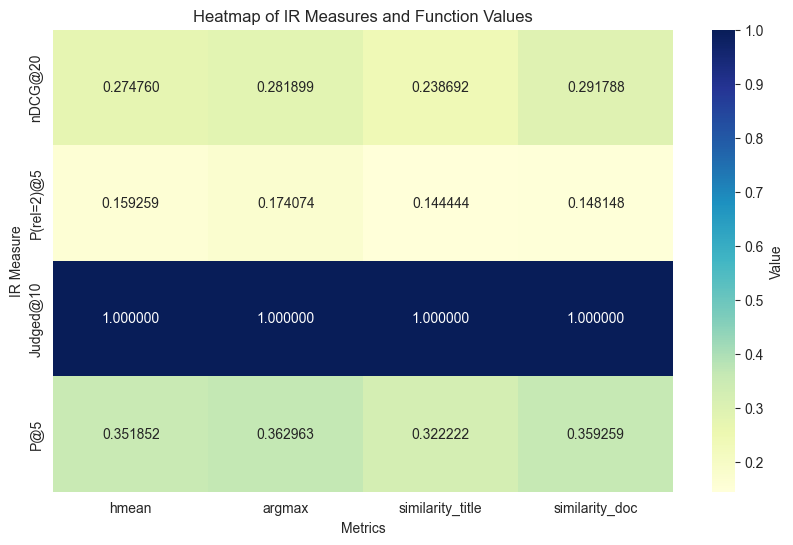

In [28]:

results_df.set_index('IR_Measure', inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, cmap="YlGnBu", fmt=".6f", cbar_kws={'label': 'Value'})
plt.title("Heatmap of IR Measures and Function Values")
plt.xlabel("Metrics")
plt.ylabel("IR Measure")
plt.show()